In [52]:
from mlrl.maze_env import make_maze_env
from mlrl.maze_state import MazeState
from mlrl.search_tree import SearchTree
from mlrl.meta_env import MetaEnv
from mlrl.manhattan_q import ManhattanQHat

object_env = make_maze_env(
    seed=1, maze_size=(2, 2), goal_reward=1, render_shape=(64, 64)
)
q_hat = ManhattanQHat(object_env)

def make_maze_search_tree(env) -> SearchTree:
    return SearchTree(env, extract_state=MazeState.extract_state)

meta_env = MetaEnv(object_env, q_hat, make_maze_search_tree, max_tree_size=10)

In [ ]:
import imageio
from mlrl.utils.render_utils import embed_mp4

filename = 'video.mp4'

actions = [
    0,
    # find best path - doesn't change anything
    1 + object_env.ACTION.index('N'),
    1 + 4*1 + object_env.ACTION.index('E'),
    1 + 4*2 + object_env.ACTION.index('S'),
    # show other paths are don't work
    *[
        1 + object_env.ACTION.index(a) 
        for a in ['S', 'E', 'W']
    ],
]

meta_env.reset()

with imageio.get_writer(filename, fps=1) as video:

    video.append_data(meta_env.render())

    for a in actions:
        meta_env.step(a)
        video.append_data(meta_env.render())

embed_mp4(filename)

In [53]:
import tensorflow as tf
import tf_agents

In [79]:
num_iterations = 10000

initial_collect_steps = 500 
collect_steps_per_iteration =   1
replay_buffer_max_length = 100000

batch_size = 64 
learning_rate = 1e-3
log_interval = 200

num_eval_episodes = 5
eval_interval = 1000

num_actions = meta_env.action_space.n

In [55]:
from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments.tf_py_environment import TFPyEnvironment
from tf_agents.environments.gym_wrapper import GymWrapper
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common

In [56]:
env = TFPyEnvironment(GymWrapper(meta_env))

# eval_object_env = make_maze_env(seed=0)
# eval_meta_env = MetaEnv(eval_object_env, q_hat, make_maze_search_tree)
# eval_env = tf_py_environment.TFPyEnvironment(tf_agents.environments.gym_wrapper.GymWrapper(eval_meta_env))

# env.reset()
# eval_env.reset()
eval_env = env

In [57]:
def mask_invalid_action_constraint_splitter(observation):
    return observation['search_tree_tokens'], observation['valid_action_mask']

In [62]:
from mlrl.search_q_model import SearchQModel

In [63]:
x = env.current_time_step().observation['search_tree_tokens']
search_q_model = SearchQModel()
search_q_model(x)

<tf.Tensor: shape=(1, 41), dtype=float32, numpy=
array([[-0.45232326, -0.28161868, -0.11756696, -0.43425208, -0.0848748 ,
        -0.45232326, -0.45232326, -0.45232326, -0.45232326, -0.45232326,
        -0.45232326, -0.45232326, -0.45232326, -0.45232326, -0.45232326,
        -0.45232326, -0.45232326, -0.45232326, -0.45232326, -0.45232326,
        -0.45232326, -0.45232326, -0.45232326, -0.45232326, -0.45232326,
        -0.45232326, -0.45232326, -0.45232326, -0.45232326, -0.45232326,
        -0.45232326, -0.45232326, -0.45232326, -0.45232326, -0.45232326,
        -0.45232326, -0.45232326, -0.45232326, -0.45232326, -0.45232326,
        -0.45232326]], dtype=float32)>

In [64]:
env.current_time_step().observation['search_tree_tokens']

<tf.Tensor: shape=(1, 10, 18), dtype=float32, numpy=
array([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]]], dtype=float32)>

In [66]:
search_q_model.q_network.summary()

Model: "q_network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_34 (Dense)            (1, 10, 192)              3648      
                                                                 
 reshape_15 (Reshape)        (1, 40, 48)               0         
                                                                 
 prepend_terminate_token_12   (1, 41, 48)              0         
 (PrependTerminateToken)                                         
                                                                 
 transformer_24 (Transformer  (1, 41, 48)              11200     
 )                                                               
                                                                 
 transformer_25 (Transformer  (1, 41, 48)              11200     
 )                                                               
                                                         

In [67]:
# fc_layer_params = (100, 50)
# action_tensor_spec = tensor_spec.from_spec(env.action_spec())
# num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

# # Define a helper function to create Dense layers configured with the right
# # activation and kernel initializer.
# def dense_layer(num_units):
#   return tf.keras.layers.Dense(
#       num_units,
#       activation=tf.keras.activations.relu,
#       kernel_initializer=tf.keras.initializers.VarianceScaling(
#           scale=2.0, mode='fan_in', distribution='truncated_normal'))

# # QNetwork consists of a sequence of Dense layers followed by a dense layer
# # with `num_actions` units to generate one q_value per available action as
# # its output.
# dense_layers = [tf.keras.layers.Flatten()] + [dense_layer(num_units) for num_units in fc_layer_params]
# q_values_layer = tf.keras.layers.Dense(
#     num_actions,
#     activation=None,
#     kernel_initializer=tf.keras.initializers.RandomUniform(
#         minval=-0.03, maxval=0.03),
#     bias_initializer=tf.keras.initializers.Constant(-0.2))
# q_net = sequential.Sequential(dense_layers + [q_values_layer])

q_net = sequential.Sequential([SearchQModel()])

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    env.time_step_spec(),
    env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    observation_and_action_constraint_splitter=mask_invalid_action_constraint_splitter,
    train_step_counter=train_step_counter
)

agent.initialize()

INFO:tensorflow:Assets written to: ram://d328d50a-394e-43ab-91d2-e0e68533e709/assets


INFO:tensorflow:Assets written to: ram://d328d50a-394e-43ab-91d2-e0e68533e709/assets


In [68]:
agent.policy.action(env.current_time_step())

PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int64, numpy=array([3])>, state=(), info=())

In [14]:
random_policy = random_tf_policy.RandomTFPolicy(env.time_step_spec(),
                                                env.action_spec(),
                                                observation_and_action_constraint_splitter=mask_invalid_action_constraint_splitter)

In [41]:
from mlrl.utils.render_utils import create_policy_eval_video, embed_mp4

embed_mp4(create_policy_eval_video(random_policy, eval_env))

In [69]:
def compute_avg_return(environment: tf_agents.environments.TFEnvironment,
                       policy: tf_agents.policies.TFPolicy,
                       num_episodes: int = 3,
                       max_steps: int = 500) -> float:

    total_return = 0.0
    for _ in range(num_episodes):

        time_step = environment.reset()
        episode_return = 0.0
        n_steps = 0
        while not time_step.is_last() and n_steps < max_steps:
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
            n_steps += 1

        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy().mean()

In [70]:
compute_avg_return(env, random_policy)

-1.3121494

In [71]:
compute_avg_return(env, agent.policy)

-0.46534756

In [72]:
from tf_agents.replay_buffers import tf_uniform_replay_buffer

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=env.batch_size,
    max_length=replay_buffer_max_length)


def collect_step(environment, policy, buffer):
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  next_time_step = environment.step(action_step.action)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)

  # Add trajectory to the replay buffer
  buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
  for _ in range(steps):
    collect_step(env, policy, buffer)

collect_data(env, random_policy, replay_buffer, initial_collect_steps)

In [73]:
iter(replay_buffer.as_dataset()).next()

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


(Trajectory(
 {'action': <tf.Tensor: shape=(), dtype=int64, numpy=4>,
  'discount': <tf.Tensor: shape=(), dtype=float32, numpy=1.0>,
  'next_step_type': <tf.Tensor: shape=(), dtype=int32, numpy=1>,
  'observation': {'search_tree_tokens': <tf.Tensor: shape=(10, 18), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
  

In [74]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

iterator = iter(dataset)

dataset

<PrefetchDataset element_spec=(Trajectory(
{'action': TensorSpec(shape=(64, 2), dtype=tf.int64, name=None),
 'discount': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'next_step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None),
 'observation': {'search_tree_tokens': TensorSpec(shape=(64, 2, 10, 18), dtype=tf.float32, name=None),
                 'valid_action_mask': TensorSpec(shape=(64, 2, 41), dtype=tf.int32, name=None)},
 'policy_info': (),
 'reward': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None)}), BufferInfo(ids=TensorSpec(shape=(64, 2), dtype=tf.int64, name=None), probabilities=TensorSpec(shape=(64,), dtype=tf.float32, name=None)))>

In [80]:
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

  # Collect a few steps using collect_policy and save to the replay buffer.
  collect_data(env, agent.collect_policy, replay_buffer, collect_steps_per_iteration)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


step = 200: loss = 0.0002542964939493686
step = 400: loss = 0.00019129746942780912
step = 600: loss = 0.00014247169019654393
step = 800: loss = 8.874463674146682e-05
step = 1000: loss = 5.59268009965308e-05
step = 1000: Average Return = -0.002149634063243866
step = 1200: loss = 8.075634832493961e-05
step = 1400: loss = 3.580074189812876e-05
step = 1600: loss = 4.988350337953307e-05
step = 1800: loss = 2.8975013265153393e-05
step = 2000: loss = 4.0193903259932995e-05
step = 2000: Average Return = 1.6610472202301025
step = 2200: loss = 2.7147778382641263e-05
step = 2400: loss = 3.07337504636962e-05
step = 2600: loss = 2.9132872441550717e-05
step = 2800: loss = 1.9923307263525203e-05
step = 3000: loss = 5.755847814725712e-05
step = 3000: Average Return = -0.002149634063243866
step = 3200: loss = 1.9053415599046275e-05
step = 3400: loss = 1.419616091880016e-05
step = 3600: loss = 1.6220297766267322e-05
step = 3800: loss = 1.796816650312394e-05
step = 4000: loss = 1.125570088333916e-05
step

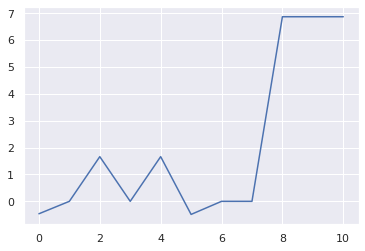

In [81]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

plt.plot(list(range(len(returns))), returns);

In [83]:
from mlrl.utils.render_utils import create_policy_eval_video, embed_mp4

eval_object_env = make_maze_env(
    seed=1, maze_size=(2, 2), goal_reward=1, render_shape=(64, 64)
)
eval_meta_env = MetaEnv(eval_object_env, q_hat, make_maze_search_tree, max_tree_size=10)
eval_env = TFPyEnvironment(GymWrapper(eval_meta_env))

embed_mp4(create_policy_eval_video(agent.policy, eval_env, max_steps=100))

In [37]:
agent._q_network.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  5100      
_________________________________________________________________
dense_1 (Dense)              multiple                  5050      
_________________________________________________________________
dense_2 (Dense)              multiple                  2091      
Total params: 12,241
Trainable params: 12,241
Non-trainable params: 0
_________________________________________________________________


In [44]:
env.current_time_step().observation

OrderedDict([('search_tree_tokens',
              <tf.Tensor: shape=(1, 10, 5), dtype=float32, numpy=
              array([[[-1., -1.,  0.,  1.,  0.],
                      [ 0.,  0.,  0.,  0.,  0.],
                      [ 0.,  0.,  0.,  0.,  0.],
                      [ 0.,  0.,  0.,  0.,  0.],
                      [ 0.,  0.,  0.,  0.,  0.],
                      [ 0.,  0.,  0.,  0.,  0.],
                      [ 0.,  0.,  0.,  0.,  0.],
                      [ 0.,  0.,  0.,  0.,  0.],
                      [ 0.,  0.,  0.,  0.,  0.],
                      [ 0.,  0.,  0.,  0.,  0.]]], dtype=float32)>),
             ('valid_action_mask',
              <tf.Tensor: shape=(1, 41), dtype=int32, numpy=
              array([[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                      0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
                    dtype=int32)>)])

<AxesSubplot:>

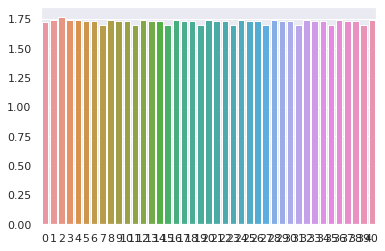

In [84]:
q_vals, *_ = agent._q_network(env.current_time_step().observation['search_tree_tokens'])
q_vals = q_vals.numpy()[0]

sns.barplot(x=list(range(q_vals.size)), y=q_vals)